In [1]:

import numpy as np
import pandas as pd
import requests
import random
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize
import folium
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn import metrics
from PIL import Image
import matplotlib.patches as mpatches
print('Libraries imported.')

Libraries imported.


In [2]:
!wget -q -O 'newyork_data.json' https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
print('Data downloaded!')
print('Loading data...')
with open('nyu_2451_34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)
    
print('data loaded succesfully!')

/bin/sh: wget: command not found
Data downloaded!
Loading data...
data loaded succesfully!


### Let's change our data into a Pandas dataframe:

In [3]:
neighborhoods_ny = pd.DataFrame(columns = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'])
for data in newyork_data['features']:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods_ny = neighborhoods_ny.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

#We take neighborhoods only from manhattan!
neighborhoods_ny = neighborhoods_ny[neighborhoods_ny['Borough'] == 'Manhattan'].reset_index(drop=True)
neighborhoods_ny.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [4]:
neighborhoods_ny.shape

(40, 4)

In [5]:
Data = pd.read_csv('Canada.csv', delimiter=';')
Data = Data[['Postcode', 'Borough', 'Neighbourhood']]
Data.drop(Data[Data['Borough'] == 'Not assigned'].index, axis=0, inplace=True)
Data = Data.reset_index(drop=True)

In [6]:
Data.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


In [7]:
Data = Data.groupby(['Postcode','Borough'])['Neighbourhood'].apply(', '.join).reset_index()

In [8]:
Data['Neighbourhood'].replace('Not assigned', "Queen's Park", inplace=True)

In [9]:
DataGeo = pd.read_csv('Geospatial_Coordinates.csv')

In [10]:
Data = pd.concat([Data, DataGeo.reindex(Data.index)], axis=1)


In [11]:
Data.head()

,Postcode,Borough,Neighbourhood,Postal Code,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",M1B,43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",M1C,43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",M1E,43.763573,-79.188711
3,M1G,Scarborough,Woburn,M1G,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,M1H,43.773136,-79.239476


In [12]:
Data.last = Data.drop('Postal Code',axis = 1)

In [13]:
DataLast = Data.last.drop('Postcode',axis = 1)

In [14]:
DataLast

,Borough,Neighbourhood,Latitude,Longitude
0,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...
98,York,Weston,43.706876,-79.518188
99,Etobicoke,Westmount,43.696319,-79.532242
100,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv...",43.688905,-79.554724
101,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.739416,-79.588437


In [15]:
DataToronto = DataLast[DataLast['Borough'] == 'Downtown Toronto'].reset_index(drop=True)

In [16]:
DataToronto

,Borough,Neighbourhood,Latitude,Longitude
0,Downtown Toronto,Rosedale,43.679563,-79.377529
1,Downtown Toronto,"Cabbagetown, St. James Town",43.667967,-79.367675
2,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
3,Downtown Toronto,Harbourfront,43.654260,-79.360636
4,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
5,Downtown Toronto,St. James Town,43.651494,-79.375418
6,Downtown Toronto,Berczy Park,43.644771,-79.373306
7,Downtown Toronto,Central Bay Street,43.657952,-79.387383
8,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568
9,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752


In [17]:

DataToronto.rename(columns = {"Neighbourhood":"Neighborhood"}, inplace = True)
data = neighborhoods_ny.append(DataToronto, True).reset_index(drop = True)


In [18]:
data

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688
5,Manhattan,Manhattanville,40.816934,-73.957385
6,Manhattan,Central Harlem,40.815976,-73.943211
7,Manhattan,East Harlem,40.792249,-73.944182
8,Manhattan,Upper East Side,40.775639,-73.960508
9,Manhattan,Yorkville,40.775930,-73.947118


## Map

In [19]:
latitudeT = 43.651070
longitudeT = -79.347015
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitudeT, longitudeT))

latitudeN = 40.7900869
longitudeN = -73.9598295
print('The geograpical coordinate of Manhattan  are {}, {}.'.format(latitudeN, longitudeN))

centerLat = (latitudeT + latitudeN)/2
centerLong = (longitudeT + longitudeN)/2

The geograpical coordinate of Toronto are 43.65107, -79.347015.
The geograpical coordinate of Manhattan  are 40.7900869, -73.9598295.


In [20]:
map_NyTo = folium.Map(location=[centerLat, centerLong], zoom_start=7, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(data['Latitude'], data['Longitude'], data['Borough'], data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_NyTo)
map_NyTo

In [1]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20200219' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


In [22]:
LIMIT = 100 
radius = 500

In [23]:
def getNearbyVenues(names, boroughs, latitudes, longitudes, radius=500):
    ind = 1
    venues_list=[]
    for name, borough, lat, lng in zip(names, boroughs, latitudes, longitudes):
        tmp=[]
        print(name)
        ind += 1
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #tmp.append([(j['venue']['name']) for j in results])
        #for item in tmp[0]:
        #    print("\t",item)
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            borough,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Borough',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print("\nDone!")
    return(nearby_venues) 

In [24]:
NyTo_venues = getNearbyVenues(names=data['Neighborhood'],
                                   boroughs = data['Borough'],
                                   latitudes = data['Latitude'],
                                   longitudes=data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 

In [25]:
NyTo_venues.shape

(4614, 8)

In [26]:
print('There are {} uniques categories.'.format(len(NyTo_venues['Venue Category'].unique())))

There are 365 uniques categories.


In [27]:
NyTo_venues.head()

,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,Manhattan,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,Manhattan,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,Manhattan,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,Manhattan,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,Manhattan,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


### Let's analyze each neighborhood.

In [28]:
# One hot encoding and grouping by neighborhoods


nyto_onehot = pd.get_dummies(NyTo_venues[['Venue Category']], prefix="", prefix_sep="")


nyto_onehot['Neighborhood'] = NyTo_venues['Neighborhood'] 
nyto_onehot['Borough'] = NyTo_venues['Borough']
nyto_onehot['Neighborhood Latitude'] = NyTo_venues['Neighborhood Latitude']
nyto_onehot['Neighborhood Longitude'] = NyTo_venues['Neighborhood Longitude']

fixed_columns = [nyto_onehot.columns[-1]] + list(nyto_onehot.columns[:-1])
nyto_onehot = nyto_onehot[fixed_columns]

nyto_grouped = nyto_onehot.groupby(['Neighborhood','Borough','Neighborhood Latitude','Neighborhood Longitude']).mean().reset_index()

   
nyto_grouped

,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,...,Vietnamese Restaurant,Volleyball Court,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",Downtown Toronto,43.650571,-79.384568,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.00,0.010000,0.000000,0.000000,0.010000,0.000000
1,Battery Park City,Manhattan,40.711932,-74.016869,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.021053,0.000000,0.021053,0.000000
2,Berczy Park,Downtown Toronto,43.644771,-79.373306,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
3,"CN Tower, Bathurst Quay, Island airport, Harbo...",Downtown Toronto,43.628947,-79.394420,0.000000,0.00,0.000000,0.000000,0.055556,0.055556,...,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
4,"Cabbagetown, St. James Town",Downtown Toronto,43.667967,-79.367675,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
5,Carnegie Hill,Manhattan,40.782683,-73.953256,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.020202,0.00,0.000000,0.00,0.00,0.010101,0.030303,0.000000,0.010101,0.030303
6,Central Bay Street,Downtown Toronto,43.657952,-79.387383,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.00,0.012048,0.000000,0.000000,0.000000,0.012048
7,Central Harlem,Manhattan,40.815976,-73.943211,0.000000,0.00,0.000000,0.046512,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
8,Chelsea,Manhattan,40.744035,-74.003116,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.020000,0.000000,0.010000,0.010000
9,Chinatown,Manhattan,40.715618,-73.994279,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.040000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.010000


### K-means Clustering

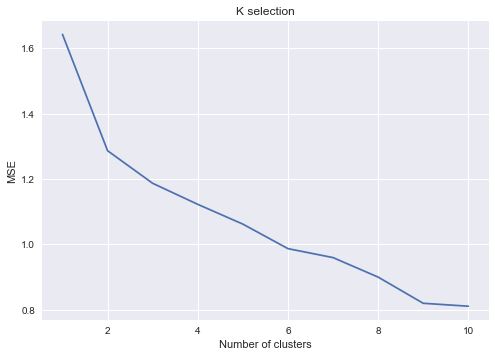

In [29]:
# Finding best k
plt.style.use("seaborn")
Ks = 11
mse = np.zeros((Ks-1))
nyto_grouped_cluster = nyto_grouped.drop(['Neighborhood','Borough','Neighborhood Latitude','Neighborhood Longitude'], 1)
for n in range(1,Ks):
    
    # set number of clusters
    kclusters = n
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(nyto_grouped_cluster)
    mse[n-1] = kmeans.inertia_

plt.plot(range(1,Ks),mse)
plt.xlabel("Number of clusters")
plt.ylabel("MSE")
plt.title("K selection")
plt.show()

In [30]:
# set number of clusters
kclusters = 9
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(nyto_grouped_cluster)
    
nyto_merged = data

# add clustering labels
nyto_merged['Cluster Labels'] = kmeans.labels_

nyto_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,Manhattan,Marble Hill,40.876551,-73.910660,6
1,Manhattan,Chinatown,40.715618,-73.994279,8
2,Manhattan,Washington Heights,40.851903,-73.936900,6
3,Manhattan,Inwood,40.867684,-73.921210,1
4,Manhattan,Hamilton Heights,40.823604,-73.949688,7
5,Manhattan,Manhattanville,40.816934,-73.957385,0
6,Manhattan,Central Harlem,40.815976,-73.943211,4
7,Manhattan,East Harlem,40.792249,-73.944182,0
8,Manhattan,Upper East Side,40.775639,-73.960508,0
9,Manhattan,Yorkville,40.775930,-73.947118,7


### Let's create map

In [31]:

map_clusters = folium.Map(location=[centerLat, centerLong], zoom_start=7, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyto_merged['Latitude'], nyto_merged['Longitude'], nyto_merged['Neighborhood'], nyto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [32]:
nyto_merged.loc[nyto_merged['Cluster Labels'] == 0] 

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
5,Manhattan,Manhattanville,40.816934,-73.957385,0
7,Manhattan,East Harlem,40.792249,-73.944182,0
8,Manhattan,Upper East Side,40.775639,-73.960508,0
13,Manhattan,Lincoln Square,40.773529,-73.985338,0
14,Manhattan,Clinton,40.759101,-73.996119,0
21,Manhattan,Tribeca,40.721522,-74.010683,0
23,Manhattan,Soho,40.722184,-74.000657,0
28,Manhattan,Battery Park City,40.711932,-74.016869,0
30,Manhattan,Carnegie Hill,40.782683,-73.953256,0
31,Manhattan,Noho,40.723259,-73.988434,0


In [33]:
nyto_merged.loc[nyto_merged['Cluster Labels'] == 1]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
3,Manhattan,Inwood,40.867684,-73.92121,1


In [34]:
nyto_merged.loc[nyto_merged['Cluster Labels'] == 2]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
38,Manhattan,Flatiron,40.739673,-73.990947,2


In [35]:
nyto_merged.loc[nyto_merged['Cluster Labels'] == 3]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
44,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,3


In [36]:
nyto_merged.loc[nyto_merged['Cluster Labels'] == 4]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
6,Manhattan,Central Harlem,40.815976,-73.943211,4
42,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,4


In [37]:
nyto_merged.loc[nyto_merged['Cluster Labels'] == 5]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
11,Manhattan,Roosevelt Island,40.76216,-73.949168,5


In [38]:
nyto_merged.loc[nyto_merged['Cluster Labels'] == 6]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,Manhattan,Marble Hill,40.876551,-73.910660,6
2,Manhattan,Washington Heights,40.851903,-73.936900,6
12,Manhattan,Upper West Side,40.787658,-73.977059,6
15,Manhattan,Midtown,40.754691,-73.981669,6
16,Manhattan,Murray Hill,40.748303,-73.978332,6
20,Manhattan,Lower East Side,40.717807,-73.980890,6
27,Manhattan,Gramercy,40.737210,-73.981376,6
35,Manhattan,Turtle Bay,40.752042,-73.967708,6
45,Downtown Toronto,St. James Town,43.651494,-79.375418,6
47,Downtown Toronto,Central Bay Street,43.657952,-79.387383,6


In [39]:
nyto_merged.loc[nyto_merged['Cluster Labels'] == 7]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
4,Manhattan,Hamilton Heights,40.823604,-73.949688,7
9,Manhattan,Yorkville,40.775930,-73.947118,7
10,Manhattan,Lenox Hill,40.768113,-73.958860,7
17,Manhattan,Chelsea,40.744035,-74.003116,7
18,Manhattan,Greenwich Village,40.726933,-73.999914,7
22,Manhattan,Little Italy,40.719324,-73.997305,7
24,Manhattan,West Village,40.734434,-74.006180,7
25,Manhattan,Manhattan Valley,40.797307,-73.964286,7
29,Manhattan,Financial District,40.707107,-74.010665,7
33,Manhattan,Midtown South,40.748510,-73.988713,7


In [40]:
nyto_merged.loc[nyto_merged['Cluster Labels'] == 8]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
1,Manhattan,Chinatown,40.715618,-73.994279,8
19,Manhattan,East Village,40.727847,-73.982226,8
26,Manhattan,Morningside Heights,40.808000,-73.963896,8
36,Manhattan,Tudor City,40.746917,-73.971219,8
39,Manhattan,Hudson Yards,40.756658,-74.000111,8
43,Downtown Toronto,Harbourfront,43.654260,-79.360636,8
49,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,8


In [41]:
tmp = np.zeros((kmeans.cluster_centers_.shape))
tmp[0,:] = kmeans.cluster_centers_[4,:]
tmp[1,:] = kmeans.cluster_centers_[0,:]
tmp[2,:] = kmeans.cluster_centers_[3,:]
tmp[3,:] = kmeans.cluster_centers_[1,:]
tmp[4,:] = kmeans.cluster_centers_[2,:]
maxi = []
for i in range(5):
    maxi.extend(tmp[i,:].argsort()[-3:][::-1])
    
args = np.asarray(list(set(maxi)))
table = pd.DataFrame(data = tmp[:,args.astype(int)], index = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], columns = nyto_grouped_cluster.columns[args.astype(int)])
table = table.transpose()

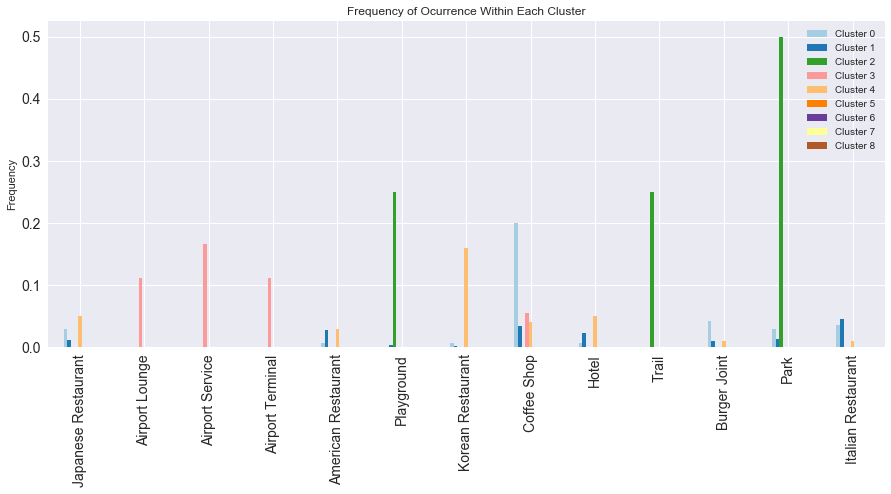

In [42]:
plt.style.use('seaborn')
ax = table.plot(kind='bar', figsize=(15,6), rot=90, fontsize = 14, colormap = 'Paired')
bars = ax.get_children()
plt.title("Frequency of Ocurrence Within Each Cluster")
plt.ylabel("Frequency")

plt.show()

In [44]:
tmp = np.zeros((kmeans.cluster_centers_.shape))
tmp[0,:] = kmeans.cluster_centers_[4,:]
tmp[1,:] = kmeans.cluster_centers_[0,:]
tmp[2,:] = kmeans.cluster_centers_[3,:]
tmp[3,:] = kmeans.cluster_centers_[1,:]
tmp[4,:] = kmeans.cluster_centers_[6,:]
tmp[6,:] = kmeans.cluster_centers_[2,:]
maxi = []
for i in range(5):
    maxi.extend(tmp[i,:].argsort()[-3:][::-1])
    
args = np.asarray(list(set(maxi)))
table = pd.DataFrame(data = tmp[:,args.astype(int)], index = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], columns = nyto_grouped_cluster.columns[args.astype(int)])
table = table.T
table.drop(["Park","Airport Service", "Airport Terminal", "Airport Lounge", "Park","Playground", "Trail"], inplace= True)

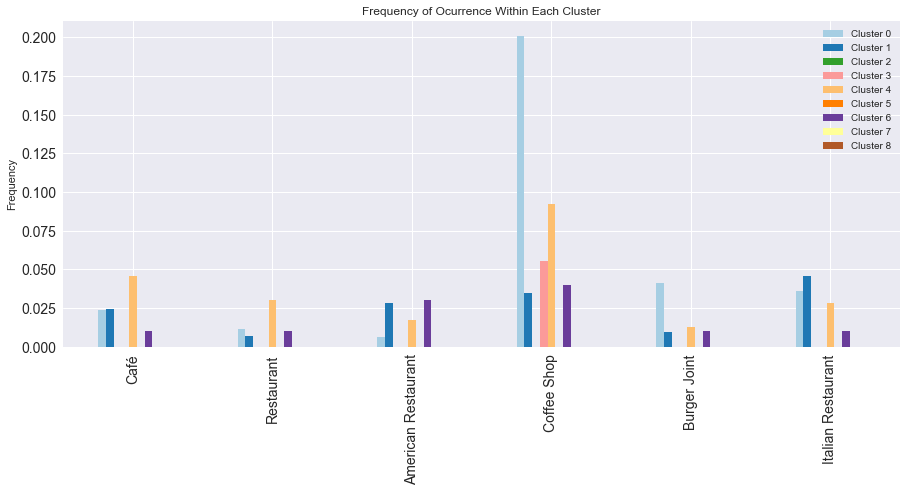

In [45]:
plt.style.use('seaborn')
ax = table.plot(kind='bar', figsize=(15,6), rot=90, fontsize = 14, colormap = 'Paired')
bars = ax.get_children()
plt.title("Frequency of Ocurrence Within Each Cluster")
plt.ylabel("Frequency")

plt.show()

In [51]:
nyto = nyto_merged.drop(["Borough", "Latitude", "Longitude"], axis = 1)

In [53]:
nyto_merged1 = pd.merge(nyto, nyto_grouped, on='Neighborhood')

In [54]:
nyto_merged1

,Neighborhood,Cluster Labels,Borough,Neighborhood Latitude,Neighborhood Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,...,Vietnamese Restaurant,Volleyball Court,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Marble Hill,6,Manhattan,40.876551,-73.910660,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.041667
1,Chinatown,8,Manhattan,40.715618,-73.994279,0.000000,0.00,0.000000,0.000000,0.000000,...,0.040000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.010000
2,Washington Heights,6,Manhattan,40.851903,-73.936900,0.011628,0.00,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.00,0.011628,0.023256,0.000000,0.011628,0.000000
3,Inwood,1,Manhattan,40.867684,-73.921210,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.00,0.035714,0.017857,0.000000,0.000000,0.017857
4,Hamilton Heights,7,Manhattan,40.823604,-73.949688,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.00,0.016949,0.000000,0.000000,0.000000,0.033898
5,Manhattanville,0,Manhattan,40.816934,-73.957385,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
6,Central Harlem,4,Manhattan,40.815976,-73.943211,0.000000,0.00,0.000000,0.046512,0.000000,...,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
7,East Harlem,0,Manhattan,40.792249,-73.944182,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
8,Upper East Side,0,Manhattan,40.775639,-73.960508,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.020000,0.000000,0.010000,0.020000
9,Yorkville,7,Manhattan,40.775930,-73.947118,0.000000,0.00,0.000000,0.000000,0.000000,...,0.020000,0.00,0.000000,0.00,0.00,0.010000,0.030000,0.000000,0.000000,0.000000


In [55]:
Cluster0 = nyto_merged1[nyto_merged1["Cluster Labels"] == 0].reset_index(drop=True)

Cluster0.drop(["Borough"], axis= 1, inplace= True)
Cluster0.drop(["Neighborhood Latitude"], axis= 1, inplace= True)
Cluster0.drop(["Neighborhood Longitude"], axis= 1, inplace= True)
Cluster0.head()

,Neighborhood,Cluster Labels,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,...,Vietnamese Restaurant,Volleyball Court,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Manhattanville,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00
1,East Harlem,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00
2,Upper East Side,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.02,0.0,0.01,0.02
3,Lincoln Square,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.02,0.02,0.0,0.00,0.01
4,Clinton,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.02,0.03,0.0,0.00,0.00


In [56]:
Cluster0

,Neighborhood,Cluster Labels,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,...,Vietnamese Restaurant,Volleyball Court,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Manhattanville,0,0.00,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.0,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.000000
1,East Harlem,0,0.00,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.0,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.000000
2,Upper East Side,0,0.00,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.0,0.0,0.00,0.000000,0.020000,0.00,0.010000,0.020000
3,Lincoln Square,0,0.00,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.0,0.0,0.00,0.020000,0.020000,0.00,0.000000,0.010000
4,Clinton,0,0.00,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.0,0.0,0.00,0.020000,0.030000,0.00,0.000000,0.000000
5,Tribeca,0,0.00,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.010000,0.01,0.0,0.0,0.01,0.030000,0.020000,0.00,0.000000,0.010000
6,Soho,0,0.02,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.0,0.0,0.00,0.010000,0.000000,0.00,0.040000,0.010000
7,Battery Park City,0,0.00,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.0,0.0,0.00,0.000000,0.021053,0.00,0.021053,0.000000
8,Carnegie Hill,0,0.00,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.020202,0.00,0.0,0.0,0.00,0.010101,0.030303,0.00,0.010101,0.030303
9,Noho,0,0.00,0.01,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.0,0.0,0.01,0.020000,0.020000,0.01,0.000000,0.020000


In [57]:

num_top_venues = 5

for hood in Cluster0['Neighborhood']:
    print("----"+hood+"----")
    temp = Cluster0[Cluster0['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Manhattanville----
                venue  freq
0         Coffee Shop  0.10
1  Italian Restaurant  0.05
2       Deli / Bodega  0.05
3  Mexican Restaurant  0.05
4  Seafood Restaurant  0.05


----East Harlem----
                       venue  freq
0         Mexican Restaurant  0.14
1            Thai Restaurant  0.07
2                     Bakery  0.07
3  Latin American Restaurant  0.07
4                       Café  0.05


----Upper East Side----
                  venue  freq
0           Art Gallery  0.07
1    Italian Restaurant  0.07
2               Exhibit  0.07
3                Bakery  0.05
4  Gym / Fitness Center  0.04


----Lincoln Square----
                venue  freq
0                Café  0.05
1  Italian Restaurant  0.05
2             Theater  0.05
3        Concert Hall  0.05
4               Plaza  0.05


----Clinton----
                  venue  freq
0               Theater  0.09
1    Italian Restaurant  0.05
2  Gym / Fitness Center  0.05
3   American Restaurant  0.04
4         

In [ ]:
put them in data frame

In [58]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted0 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted0['Neighborhood'] = Cluster0['Neighborhood']

for ind in np.arange(Cluster0.shape[0]):
    neighborhoods_venues_sorted0.iloc[ind, 1:] = return_most_common_venues(Cluster0.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted0

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Manhattanville,Coffee Shop,Deli / Bodega,Mexican Restaurant,Seafood Restaurant,Italian Restaurant
1,East Harlem,Mexican Restaurant,Bakery,Latin American Restaurant,Thai Restaurant,Deli / Bodega
2,Upper East Side,Art Gallery,Italian Restaurant,Exhibit,Bakery,Gym / Fitness Center
3,Lincoln Square,Theater,Plaza,Café,Italian Restaurant,Concert Hall
4,Clinton,Theater,Gym / Fitness Center,Italian Restaurant,American Restaurant,Coffee Shop
5,Tribeca,American Restaurant,Italian Restaurant,Park,Café,Men's Store
6,Soho,Clothing Store,Boutique,Art Gallery,Women's Store,Men's Store
7,Battery Park City,Park,Coffee Shop,Hotel,Gym,Memorial Site
8,Carnegie Hill,Coffee Shop,Café,Pizza Place,Gym,Cosmetics Shop
9,Noho,Italian Restaurant,Hotel,Cocktail Bar,Pizza Place,French Restaurant


In [59]:
Cluster1 = nyto_merged1[nyto_merged1["Cluster Labels"] == 1].reset_index(drop=True)

Cluster1.drop(["Borough"], axis= 1, inplace= True)
Cluster1.drop(["Neighborhood Latitude"], axis= 1, inplace= True)
Cluster1.drop(["Neighborhood Longitude"], axis= 1, inplace= True)
Cluster1.drop(["Cluster Labels"], axis= 1, inplace= True)
Cluster1.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Vietnamese Restaurant,Volleyball Court,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Inwood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.035714,0.017857,0.0,0.0,0.017857


In [60]:
num_top_venues = 5

for hood in Cluster1['Neighborhood']:
    print("----"+hood+"----")
    temp = Cluster1[Cluster1['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Inwood----
                venue  freq
0  Mexican Restaurant  0.07
1              Lounge  0.07
2          Restaurant  0.05
3                Café  0.05
4         Pizza Place  0.05




In [61]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted1 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted1['Neighborhood'] = Cluster1['Neighborhood']

for ind in np.arange(Cluster1.shape[0]):
    neighborhoods_venues_sorted1.iloc[ind, 1:] = return_most_common_venues(Cluster1.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Inwood,Mexican Restaurant,Lounge,Restaurant,Pizza Place,Café


In [62]:
Cluster2 = nyto_merged1[nyto_merged1["Cluster Labels"] == 2].reset_index(drop=True)

Cluster2.drop(["Borough"], axis= 1, inplace= True)
Cluster2.drop(["Neighborhood Latitude"], axis= 1, inplace= True)
Cluster2.drop(["Neighborhood Longitude"], axis= 1, inplace= True)
Cluster2.drop(["Cluster Labels"], axis= 1, inplace= True)
Cluster2.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Vietnamese Restaurant,Volleyball Court,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Flatiron,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.01,0.0,0.0,0.02,0.0,0.01,0.04


In [63]:
num_top_venues = 5

for hood in Cluster2['Neighborhood']:
    print("----"+hood+"----")
    temp = Cluster2[Cluster2['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Flatiron----
                  venue  freq
0           Yoga Studio  0.04
1   Japanese Restaurant  0.04
2  Gym / Fitness Center  0.04
3   American Restaurant  0.04
4                  Café  0.04




In [64]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted2 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted2['Neighborhood'] = Cluster2['Neighborhood']

for ind in np.arange(Cluster2.shape[0]):
    neighborhoods_venues_sorted2.iloc[ind, 1:] = return_most_common_venues(Cluster2.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Flatiron,Yoga Studio,American Restaurant,Japanese Restaurant,Café,Gym / Fitness Center


In [65]:
Cluster3 = nyto_merged1[nyto_merged1["Cluster Labels"] == 3].reset_index(drop=True)

Cluster3.drop(["Borough"], axis= 1, inplace= True)
Cluster3.drop(["Neighborhood Latitude"], axis= 1, inplace= True)
Cluster3.drop(["Neighborhood Longitude"], axis= 1, inplace= True)
Cluster3.drop(["Cluster Labels"], axis= 1, inplace= True)
Cluster3.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Vietnamese Restaurant,Volleyball Court,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Ryerson, Garden District",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0


In [66]:
num_top_venues = 5

for hood in Cluster3['Neighborhood']:
    print("----"+hood+"----")
    temp = Cluster3[Cluster3['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ryerson, Garden District----
                 venue  freq
0          Coffee Shop  0.08
1       Clothing Store  0.07
2       Cosmetics Shop  0.03
3                 Café  0.03
4  Japanese Restaurant  0.03




In [67]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted3 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted3['Neighborhood'] = Cluster3['Neighborhood']

for ind in np.arange(Cluster3.shape[0]):
    neighborhoods_venues_sorted3.iloc[ind, 1:] = return_most_common_venues(Cluster3.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Ryerson, Garden District",Coffee Shop,Clothing Store,Café,Japanese Restaurant,Cosmetics Shop


In [68]:
Cluster4 = nyto_merged1[nyto_merged1["Cluster Labels"] == 4].reset_index(drop=True)

Cluster4.drop(["Borough"], axis= 1, inplace= True)
Cluster4.drop(["Neighborhood Latitude"], axis= 1, inplace= True)
Cluster4.drop(["Neighborhood Longitude"], axis= 1, inplace= True)
Cluster4.drop(["Cluster Labels"], axis= 1, inplace= True)
Cluster4.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Vietnamese Restaurant,Volleyball Court,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Central Harlem,0.0,0.0,0.000000,0.046512,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,Church and Wellesley,0.0,0.0,0.012048,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.012048,0.0,0.0,0.0,0.0,0.0,0.0,0.012048,0.0,0.012048


In [69]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted4 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted4['Neighborhood'] = Cluster4['Neighborhood']

for ind in np.arange(Cluster4.shape[0]):
    neighborhoods_venues_sorted4.iloc[ind, 1:] = return_most_common_venues(Cluster4.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted4

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Central Harlem,Cosmetics Shop,Chinese Restaurant,French Restaurant,Bar,American Restaurant
1,Church and Wellesley,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant


In [70]:
Cluster5 = nyto_merged1[nyto_merged1["Cluster Labels"] == 5].reset_index(drop=True)

Cluster5.drop(["Borough"], axis= 1, inplace= True)
Cluster5.drop(["Neighborhood Latitude"], axis= 1, inplace= True)
Cluster5.drop(["Neighborhood Longitude"], axis= 1, inplace= True)
Cluster5.drop(["Cluster Labels"], axis= 1, inplace= True)
Cluster5.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Vietnamese Restaurant,Volleyball Court,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Roosevelt Island,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted5 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted5['Neighborhood'] = Cluster5['Neighborhood']

for ind in np.arange(Cluster5.shape[0]):
    neighborhoods_venues_sorted5.iloc[ind, 1:] = return_most_common_venues(Cluster5.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted5

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Roosevelt Island,Park,Sandwich Place,Deli / Bodega,Coffee Shop,Scenic Lookout


In [72]:
Cluster6 = nyto_merged1[nyto_merged1["Cluster Labels"] == 6].reset_index(drop=True)

Cluster6.drop(["Borough"], axis= 1, inplace= True)
Cluster6.drop(["Neighborhood Latitude"], axis= 1, inplace= True)
Cluster6.drop(["Neighborhood Longitude"], axis= 1, inplace= True)
Cluster6.drop(["Cluster Labels"], axis= 1, inplace= True)
Cluster6.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Vietnamese Restaurant,Volleyball Court,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Marble Hill,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.041667
1,Washington Heights,0.011628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.011628,0.023256,0.0,0.011628,0.000000
2,Upper West Side,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01,0.0,0.0,0.0,0.0,0.040000,0.010000,0.0,0.000000,0.010000
3,Midtown,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.010000,0.010000
4,Murray Hill,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01,0.0,0.0,0.0,0.0,0.010000,0.000000,0.0,0.000000,0.000000


In [73]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted6 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted6['Neighborhood'] = Cluster6['Neighborhood']

for ind in np.arange(Cluster6.shape[0]):
    neighborhoods_venues_sorted6.iloc[ind, 1:] = return_most_common_venues(Cluster6.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted6

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Marble Hill,Coffee Shop,Gym,Sandwich Place,Yoga Studio,Shopping Mall
1,Washington Heights,Café,Bakery,Grocery Store,Deli / Bodega,Mobile Phone Shop
2,Upper West Side,Italian Restaurant,Wine Bar,Bar,Coffee Shop,Mediterranean Restaurant
3,Midtown,Hotel,Sporting Goods Shop,Clothing Store,Coffee Shop,Bakery
4,Murray Hill,Sandwich Place,Coffee Shop,American Restaurant,Gym / Fitness Center,Japanese Restaurant
5,Lower East Side,Café,Pizza Place,Coffee Shop,Chinese Restaurant,Art Gallery
6,Gramercy,Italian Restaurant,Pizza Place,Mexican Restaurant,Bagel Shop,Thai Restaurant
7,Turtle Bay,Italian Restaurant,Coffee Shop,Sushi Restaurant,Steakhouse,Wine Bar
8,St. James Town,Coffee Shop,Café,Restaurant,Clothing Store,Diner
9,Central Bay Street,Coffee Shop,Italian Restaurant,Ice Cream Shop,Sandwich Place,Japanese Restaurant


In [74]:
Cluster7 = nyto_merged1[nyto_merged1["Cluster Labels"] == 7].reset_index(drop=True)

Cluster7.drop(["Borough"], axis= 1, inplace= True)
Cluster7.drop(["Neighborhood Latitude"], axis= 1, inplace= True)
Cluster7.drop(["Neighborhood Longitude"], axis= 1, inplace= True)
Cluster7.drop(["Cluster Labels"], axis= 1, inplace= True)
Cluster7.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Vietnamese Restaurant,Volleyball Court,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Hamilton Heights,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.016949,0.00,0.0,0.00,0.033898
1,Yorkville,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.02,0.0,0.0,0.0,0.0,0.010000,0.03,0.0,0.00,0.000000
2,Lenox Hill,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.010000,0.02,0.0,0.01,0.000000
3,Chelsea,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.000000,0.02,0.0,0.01,0.010000
4,Greenwich Village,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.02,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.00,0.010000


In [75]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted7 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted7['Neighborhood'] = Cluster7['Neighborhood']

for ind in np.arange(Cluster7.shape[0]):
    neighborhoods_venues_sorted7.iloc[ind, 1:] = return_most_common_venues(Cluster7.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted7

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Hamilton Heights,Pizza Place,Café,Coffee Shop,Mexican Restaurant,Deli / Bodega
1,Yorkville,Italian Restaurant,Bar,Gym,Coffee Shop,Deli / Bodega
2,Lenox Hill,Coffee Shop,Italian Restaurant,Sushi Restaurant,Pizza Place,Cocktail Bar
3,Chelsea,Coffee Shop,Italian Restaurant,Bakery,Ice Cream Shop,Hotel
4,Greenwich Village,Italian Restaurant,Sushi Restaurant,Clothing Store,Café,Indian Restaurant
5,Little Italy,Bakery,Café,Salon / Barbershop,Cocktail Bar,Sandwich Place
6,West Village,Italian Restaurant,New American Restaurant,Cosmetics Shop,Park,Wine Bar
7,Manhattan Valley,Bar,Indian Restaurant,Pizza Place,Coffee Shop,Mexican Restaurant
8,Financial District,Coffee Shop,American Restaurant,Bar,Hotel,Pizza Place
9,Midtown South,Korean Restaurant,Hotel,Japanese Restaurant,Hotel Bar,Coffee Shop


In [76]:
Cluster8 = nyto_merged1[nyto_merged1["Cluster Labels"] == 8].reset_index(drop=True)

Cluster8.drop(["Borough"], axis= 1, inplace= True)
Cluster8.drop(["Neighborhood Latitude"], axis= 1, inplace= True)
Cluster8.drop(["Neighborhood Longitude"], axis= 1, inplace= True)
Cluster8.drop(["Cluster Labels"], axis= 1, inplace= True)
Cluster8.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Vietnamese Restaurant,Volleyball Court,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Chinatown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.040000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.010000
1,East Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.020000,0.0,0.0,0.0,0.0,0.040000,0.010000,0.0,0.0,0.000000
2,Morningside Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
3,Tudor City,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.012346,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.012346
4,Hudson Yards,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.012346,0.012346,0.0,0.0,0.000000


In [77]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted8 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted8['Neighborhood'] = Cluster8['Neighborhood']

for ind in np.arange(Cluster8.shape[0]):
    neighborhoods_venues_sorted8.iloc[ind, 1:] = return_most_common_venues(Cluster8.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted8

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Chinatown,Chinese Restaurant,Cocktail Bar,American Restaurant,Vietnamese Restaurant,Hotpot Restaurant
1,East Village,Bar,Ice Cream Shop,Cocktail Bar,Wine Bar,Chinese Restaurant
2,Morningside Heights,Park,Coffee Shop,American Restaurant,Bookstore,Burger Joint
3,Tudor City,Mexican Restaurant,Park,Café,Pizza Place,Diner
4,Hudson Yards,American Restaurant,Hotel,Gym / Fitness Center,Italian Restaurant,Café
5,Harbourfront,Coffee Shop,Pub,Bakery,Park,Theater
6,"Harbourfront East, Toronto Islands, Union Station",Coffee Shop,Aquarium,Hotel,Italian Restaurant,Café


In [78]:
cl0 = pd.DataFrame(Cluster0['Neighborhood'])
cl1 = pd.DataFrame(Cluster1['Neighborhood'])
cl2 = pd.DataFrame(Cluster2['Neighborhood'])
cl3 = pd.DataFrame(Cluster3['Neighborhood'])
cl4 = pd.DataFrame(Cluster4['Neighborhood'])
cl5 = pd.DataFrame(Cluster5['Neighborhood'])
cl6 = pd.DataFrame(Cluster6['Neighborhood'])
cl7 = pd.DataFrame(Cluster7['Neighborhood'])
cl8 = pd.DataFrame(Cluster8['Neighborhood'])

In [79]:
def create_waffle_chart(categories, values, height, width, colormap, value_sign=''):

    # compute the proportion of each category with respect to the total
    total_values = sum(values)
    category_proportions = [(float(value) / total_values) for value in values]

    # compute the total number of tiles
    total_num_tiles = width * height # total number of tiles
    print ('Total number of tiles is', total_num_tiles)
    
    # compute the number of tiles for each catagory
    tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

    # print out number of tiles per category
    for i, tiles in enumerate(tiles_per_category):
        print (categories[i] + ': ' + str(tiles))
    
    # initialize the waffle chart as an empty matrix
    waffle_chart = np.zeros((height, width))

    # define indices to loop through waffle chart
    category_index = 0
    tile_index = 0

    # populate the waffle chart
    for col in range(width):
        for row in range(height):
            tile_index += 1

            # if the number of tiles populated for the current category 
            # is equal to its corresponding allocated tiles...
            if tile_index > sum(tiles_per_category[0:category_index]):
                # ...proceed to the next category
                category_index += 1       
            
            # set the class value to an integer, which increases with class
            waffle_chart[row, col] = category_index
    
    # instantiate a new figure object
    fig = plt.figure()

    # use matshow to display the waffle chart
    plt.matshow(waffle_chart, cmap=colormap)
    plt.colorbar()

    # get the axis
    ax = plt.gca()

    # set minor ticks
    ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # add dridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    plt.xticks([])
    plt.yticks([])

    # compute cumulative sum of individual categories to match color schemes between chart and legend
    values_cumsum = np.cumsum(values)
    total_values = values_cumsum[len(values_cumsum) - 1]
    #print(values_cumsum)

    # create legend
    legend_handles = []
    for i, category in enumerate(categories):
        if value_sign == '%':
            label_str = category + ' (' + str(values[i]) + value_sign + ')'
        else:
            label_str = category + ' (' + value_sign + str(values[i]) + ')'
            
        #color_val = colormap((float(values_cumsum[i])/total_values))
        color_val = colormap(np.linspace(0,1,9)[i])
        #print(np.arange(1,6)[i]/5)
        legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

    # add legend to chart
    plt.legend(
        handles=legend_handles,
        loc='lower center', 
        ncol=len(categories),
        bbox_to_anchor=(0., -0.2, 0.95, .1)
    )



Total number of tiles is 400
Cluster 0: 136
Cluster 1: 7
Cluster 2: 7
Cluster 3: 7
Cluster 4: 14
Cluster 5: 7
Cluster 6: 81
Cluster 7: 95
Cluster 8: 47


<Figure size 576x396 with 0 Axes>

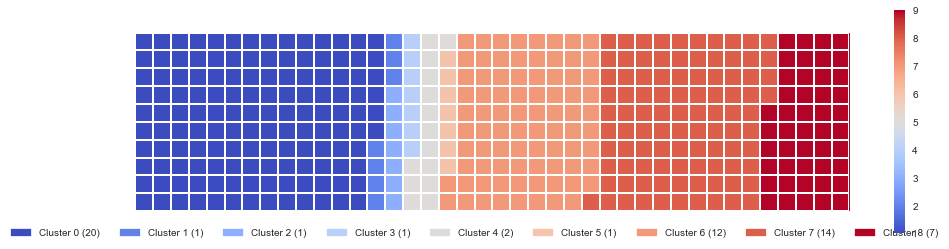

In [80]:
index = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8']
portions = [cl0.shape[0], cl1.shape[0], cl2.shape[0], cl3.shape[0], cl4.shape[0], cl5.shape[0], cl6.shape[0], cl7.shape[0], cl8.shape[0]]
width = 40 # width of chart
height = 10 # height of chart

categories = index # categories
values = portions # correponding values of categorie'

colormap = plt.cm.coolwarm# color map class
create_waffle_chart(categories, values, height, width, colormap)